In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
from tools import *
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from scipy.stats import multivariate_normal
from scipy.misc import derivative
from scipy.linalg import fractional_matrix_power
from scipy.stats import wishart
from IPython.display import Latex
import sys
import time

In [4]:
def logtargetpdf(x, target, kernel):
    lnp = 0.0
    if (target == 'Exp'):
            lnp = -x if (x>=0) else -500
    elif (target == 'Folded_Gaussian'):
            lnp = -x*x/2 if (x>=0) else -500
    elif (target == 'N01_T2'):
            lnp = -x*x/2
    elif (target == 'N01_Logistic'):
            lnp = -x*x/2
    return (lnp)

def transform_x(x,transform):
    y = 0.0
    if (transform == 'Exp(1)_CDF'):
        y = np.exp(-x)
    elif (transform == 't(2)_CDF'):
        y = 1 - 1/2 * (1+np.sqrt(1-2/(np.square(x)+2))) if x<0 else 1/2 * (1+np.sqrt(1-2/(np.square(x)+2)))
    elif (transform == 'logistic_CDF'):
        y = 1/(1+np.exp(-x))
    return y

def transform_inverse(x,transform):
    y = 0.0
    if (transform == 'Exp(1)_CDF'):
        y = -np.log(x)
    elif (transform == 't(2)_CDF'):
        y = np.sqrt(2/(1-np.square(2*x-1))-2) * (-1 if x<0.5 else 1)
    elif (transform == 'logistic_CDF'):
        y = -np.log(1/x-1)
    return y

def log_proposal_ratio(x,transform,kernel):
    ratio = 0.0
    if 'Trans' in kernel:
        if (transform == 'Exp(1)_CDF'):
            ratio = -x
        elif (transform == 't(2)_CDF'):
            ratio = -3/2*np.log(1+x**2/2)
        elif (transform == 'logistic_CDF'):
            ratio = -x - 2*np.log(1+np.exp(-x))
    return ratio

In [5]:
#MCMC sampling implementation
# np.random.seed(121)
begin_total = time.time()
nround = int(10e5)
burnin = int(10e4)
size = len(range(-burnin,nround))
sigmaset = [0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 1, 1.1, 1.3, 1.5, 1.7,
                    1.8, 1.9, 2, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.8,
                    3.0, 3.2, 3.5, 4, 4.5, 5, 6, 7, 8]
kernelset = ['Uniform','TransUniform','TransBactrian','TransStrawHat']
targetset = {'Exp':'Exp(1)_CDF', 'Folded_Gaussian':'Exp(1)_CDF', 'N01_T2':'t(2)_CDF', 'N01_Logistic':'logistic_CDF'}

sample_Normal = np.random.normal(size = size)
sample_Uniform = np.random.uniform(low=-np.sqrt(3), high=np.sqrt(3), size=size)
sample_bactrian = random_bactrian(size = size)
sample_strawhat = random_strawhat(size=size)
target_result = {}

for target,transform in targetset.items():
    eff_kernel = {}; Pjump_kernel = {}; Exx2_kernel = {}; Rho_kernel={}; Sample_kernel={}; Quantile_kernel={}
    for kernel in kernelset:
        Eff = []; Pjump = []; Exx2=[]; Rho=[]; Sample=[]; Quantile=[]
        for sigma in sigmaset:
            begin_loop = time.time()
            exx2 = 0; accept = 0; 
            x = abs(np.random.random() - 0.5)
            y = np.zeros(nround)
            logtargetold = logtargetpdf(x,target,kernel) - log_proposal_ratio(x,transform,kernel)
            for j in range(-burnin,nround):
                x_trans = transform_x(x,transform) if 'Trans' in kernel else x
                if (j==0):
                    accept = 0;
                if 'Gaussian' in kernel:
                    xnew_trans = x_trans + sample_Normal[j+burnin] * sigma
                elif 'Uniform' in kernel:
                    xnew_trans = x_trans + sample_Uniform[j+burnin] *sigma
                elif 'Bactrian' in kernel:
                    xnew_trans = x_trans + sample_bactrian[j+burnin] *sigma
                elif 'StrawHat' in kernel:
                    xnew_trans = x_trans + sample_strawhat[j+burnin] *sigma

                if (('Trans' in kernel) & (not (0 <= xnew_trans <= 1))):
                    xnew_trans = reflect(xnew_trans, xL=0, xU=1)
                if (((target=='Exp') | (target=='Folded_Gaussian')) & ('Trans' not in kernel)) & (xnew_trans<0):
                    xnew_trans = -xnew_trans
                
                xnew = transform_inverse(xnew_trans,transform) if ('Trans' in kernel) else xnew_trans
                
                logtargetnew = logtargetpdf(xnew,target,kernel) - log_proposal_ratio(xnew,transform,kernel)
                pi_dif = logtargetnew - logtargetold
                if ((pi_dif>0) | (np.exp(pi_dif)>np.random.random())):
                    x = xnew
                    logtargetold = logtargetnew
                    accept += 1
                if (j>=0):
                    y[j] = x
            eff = (Eff_IntegratedCorrelationTime(y))
            rho = [rho_k(y,i) for i in range(1,11)]
            exx2 = sum(np.square(y[1:] - y[:-1]))
            quantile = [Eff_quantile(y,i) for i in [0.05,0.25,0.5,0.75,0.95]]
            Eff.append(eff)
            Pjump.append(accept/nround)
            Exx2.append(exx2/nround)
            Rho.append(rho)
            Sample.append(y.copy())
            Quantile.append(quantile)
#             print ('Target:',target,'|Kernel:',kernel,'|sigma:',sigma,'|eff:',round(eff,4), '|Pjump:', round(accept/nround,4), '|Exx2:', round(exx2/nround,4),
#                    '|rho1:', round(rho[0],4), '|rho2:', round(rho[1],4) ,'|Time:',round((time.time()-begin_loop),2),sep='')
            display(Latex('Target:{} | Kernel:{} | $\sigma$:{} | eff:{} | $P_{{jump}}$:{} | Exx2:{} | $\\rho_1$:{} | $\\rho_2$:{} | $E_{{0.05}}$:{} | $E_{{0.25}}$:{} | $E_{{0.50}}$:{} | Time:{}'.format(
                    target,kernel,sigma,round(eff,4),round(accept/nround,4),round(exx2/nround,4),round(rho[0],4),round(rho[1],4),
                    round(quantile[0],4),round(quantile[1],4),round(quantile[2],4),round((time.time()-begin_loop),2))))
        eff_kernel[kernel] = Eff
        Pjump_kernel[kernel] = Pjump
        Exx2_kernel[kernel] = Exx2
        Rho_kernel[kernel] = Rho
        Sample_kernel[kernel] = Sample
        Quantile_kernel[kernel] = Quantile
    target_result[target] = [eff_kernel,Pjump_kernel,Exx2_kernel,Rho_kernel,Sample_kernel,Quantile_kernel]
print('总共用时: %f'% (time.time()-begin_total))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

总共用时: 8333.622029


In [6]:
name = ['Kernel' ,'Sigma', 'Eff', 'Pjump', 'Exx2', 'rho1', 'rho2', 'E_5%', 'E_25%', 'E_50%']
print('{:<25} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8}'.format(*name))

for target in targetset:
    kernel_info = {}
    print('                                      ',target)
    for kernel in kernelset:
        index = [np.argmax(target_result[target][0][i]) for i in kernelset]
        index_need = index[np.where(np.array(kernelset)==kernel)[0][0]]
        info = [target_result[target][i][kernel][index_need] for i in range(len(target_result[target]))]
        rho1 = info[3][0]; rho2 = info[3][1]
        E05 = info[5][0]; E25 = info[5][1]; E50 = info[5][2]
#         kernel_info[kernel] = np.round(np.concatenate([[sigmaset[index_need]],info[0:3],[rho1,rho2]]),3)
        kernel_info[kernel] = np.round(np.concatenate([[sigmaset[index_need]],info[0:3],[rho1,rho2],[E05,E25,E50]]),3)
        kernel_info[kernel] = kernel_info[kernel].tolist()
        kernel_info[kernel].insert(0,kernel)
        print('{:<25} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8} {:<8}'.format(*kernel_info[kernel]))

Kernel                    Sigma    Eff      Pjump    Exx2     rho1     rho2     E_5%     E_25%    E_50%   
                                       Exp
Uniform                   2.3      0.16     0.433    0.586    0.705    0.504    0.145    0.162    0.189   
TransUniform              0.8      1.306    1.0      2.276    -0.143   0.034    1.019    1.169    1.397   
TransBactrian             0.9      2.0      1.0      2.825    -0.41    0.258    1.044    1.495    2.652   
TransStrawHat             1.0      2.079    1.0      2.952    -0.47    0.361    1.02     1.372    3.208   
                                       Folded_Gaussian
Uniform                   1.5      0.277    0.543    0.326    0.55     0.309    0.315    0.318    0.329   
TransUniform              0.9      1.062    0.833    0.75     -0.033   0.004    0.81     0.871    0.82    
TransBactrian             1.0      1.922    0.837    0.96     -0.324   0.112    0.694    0.894    1.268   
TransStrawHat             0.9      2.211    0.

### The plot below is the probability density of  target after transformed:

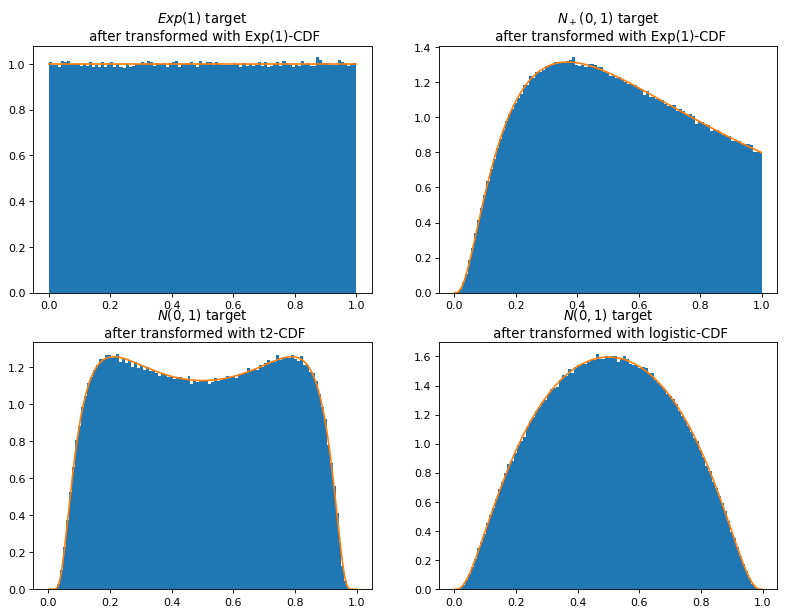

In [7]:
from IPython.display import HTML
from IPython.display import display

# Taken from https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)

############### Write code below ##################

def logistic_inverse(x):
    return(-np.log(1/x-1))
#     return scipy.stats.logistic.ppf(x)

def logistic_diff(x):
    return(abs(1/x+1/(1-x)))
#     return abs(derivative(logistic_inverse,x,dx=1e-6))

def t_inverse(x):
    return scipy.stats.t.ppf(x,df=2)

def t_diff(x):
    return abs(derivative(t_inverse,x,dx=1e-6))

def exp_inverse(x):
    return(-np.log(x))

def exp_diff(x):
    return(abs(1/x))

from matplotlib.pyplot import figure
figure(num=None, figsize=(12,9), dpi=80, facecolor='w', edgecolor='k')

ori = np.random.exponential(size=1000000,scale=1.0)
trans = np.exp(-ori)
xindex = np.arange(0.001,0.999,0.001)
yindex = np.ones(len(xindex))
plt.subplot(221)
plt.hist(trans, bins=100, density=True)
plt.plot(xindex,yindex)
plt.gca().set_title('$Exp(1)$ target \n after transformed with Exp(1)-CDF')

ori = abs(np.random.normal(size=1000000))
trans = np.exp(-ori)
xindex = np.arange(0.001,0.999,0.001)
inverse = np.array([exp_inverse(i) for i in xindex])
diff_term = np.array([exp_diff(i) for i in xindex])
yindex = 2*scipy.stats.norm.pdf(inverse) * diff_term
plt.subplot(222)
plt.hist(trans, bins=100, density=True)
plt.plot(xindex,yindex)
plt.gca().set_title('$N_+(0,1)$ target \n after transformed with Exp(1)-CDF')


ori = np.random.normal(size=1000000)
trans = scipy.stats.t.cdf(x=ori,df=2)
xindex = np.arange(0.001,0.999,0.001)
inverse = np.array([t_inverse(i) for i in xindex])
diff_term = np.array([t_diff(i) for i in xindex])
yindex = scipy.stats.norm.pdf(inverse) * diff_term
plt.subplot(223)
plt.hist(trans, bins=100, density=True)
plt.plot(xindex,yindex)
plt.gca().set_title('$N(0,1)$ target \n after transformed with t2-CDF')

ori = np.random.normal(size=1000000)
trans = scipy.stats.logistic.cdf(x=ori)
xindex = np.arange(0.001,0.999,0.001)
inverse = np.array([logistic_inverse(i) for i in xindex])
diff_term = np.array([logistic_diff(i) for i in xindex])
yindex = scipy.stats.norm.pdf(inverse) * diff_term
plt.subplot(224)
plt.hist(trans, bins=100, density=True)
plt.plot(xindex,yindex)
plt.gca().set_title('$N(0,1)$ target \n after transformed with logistic-CDF')

plt.show()